In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from IPython.display import display
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import talib
from talib import abstract
import pickle
from sklearn.preprocessing import minmax_scale, maxabs_scale
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from itertools import compress
import random
from sklearn.metrics import plot_roc_curve, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
%matplotlib inline

In [10]:
nasdaq_tickers_df = pd.read_csv("nasdaqlisted.txt", sep="|")
nasdaq_tickers = [t for t in nasdaq_tickers_df["Symbol"][:-1].tolist() if not pd.isnull(t)]

In [15]:
# Set the start and end date
start_date = '1990-01-01'
end_date = str(date.today())

# Get the data
snp = yf.download('SNP', start_date, end_date)
snp.index = [str(d)[:10] for d in snp.index]
test = yf.download(np.random.choice(nasdaq_tickers), start_date, end_date)["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
def visualize_stock(stock_series, ticker=None):
    stock_series.plot(figsize=(10, 7))
    if ticker == None:
        try: 
            ticker = stock_series.name
        except:
            raise Exception("No ticker name was provided")
    plt.title("Adj Close Price of %s" % ticker, fontsize=16)

    # Define the labels for x-axis and y-axis
    plt.ylabel('Price', fontsize=14)
    plt.xlabel('Year', fontsize=14)

    # Plot the grid lines
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

    # Show the plot
    plt.show()

In [2]:
def visualize_stock_mult(stock_series, t=None, figsize=(15,10)):
    if not isinstance(stock_series,list):
        stock_series = [stock_series]
    plt.figure(figsize=figsize)
    for series in stock_series:
        plt.plot(series, label=series.name)
    title = t if t is not None else ""
    plt.title(title, fontsize=16)

    # Define the labels for x-axis and y-axis
    plt.ylabel('Price', fontsize=14)
    plt.xlabel('Year', fontsize=14)

    # Plot the grid lines
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.legend()

    # Show the plot
    plt.show()

In [20]:
def normalize(ts:pd.Series) -> pd.Series:
    """
    Normalize the time series. If the series includes negative numbers normalizes to [-1,1]. Otherwise normalizes to [0,1].
    """
    copy = ts.copy()
    min_ = max(0,min(copy))
    copy -= min_
    max_ = max(abs(copy))
    copy /= max_
    return copy

In [8]:
def clean(ts: pd.Series) -> pd.Series:
    """
    Clean the time series. Remove nans in the beginning and fill in missing values
    """
    copy = ts.copy()
    i1 = copy.first_valid_index()
    copy = copy[i1:].interpolate()
    return copy

In [6]:
f500 = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

tickers_list = f500.Symbol.to_list()
# print(f500)
# Get the data for this tickers from yahoo finance
f500_data = yf.download(tickers_list,start_date,end_date, auto_adjust=True)['Close']
f500_data = f500_data.iloc[f500_data.index.argsort()]
display(f500_data)

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,0.265325,NaN,NaN,5.875000,1.872443,NaN,1.188340,...,NaN,4.339764,4.168207,0.869245,NaN,NaN,NaN,NaN,1.902435,NaN
1990-01-03,NaN,NaN,NaN,0.267106,NaN,NaN,5.812500,1.879202,NaN,1.247024,...,NaN,4.326369,4.126523,0.869245,NaN,NaN,NaN,NaN,1.936408,NaN
1990-01-04,NaN,NaN,NaN,0.267997,NaN,NaN,5.625000,1.875822,NaN,1.305707,...,NaN,4.219214,4.084843,0.834475,NaN,NaN,NaN,NaN,1.936408,NaN
1990-01-05,NaN,NaN,NaN,0.268887,NaN,NaN,5.750000,1.855543,NaN,1.335049,...,NaN,4.179029,4.064002,0.886630,NaN,NaN,NaN,NaN,1.936408,NaN
1990-01-08,NaN,NaN,NaN,0.270668,NaN,NaN,5.750000,1.865055,NaN,1.352692,...,NaN,4.138850,4.126523,0.851860,NaN,NaN,NaN,NaN,1.936408,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,128.250000,12.99,168.639999,157.220001,134.460007,146.559998,259.279999,102.650002,288.459991,373.440002,...,60.590000,74.250000,95.589996,32.770000,91.099998,111.239998,106.320000,301.640015,55.029999,156.529999
2022-09-01,128.929993,12.93,172.149994,157.960007,138.449997,147.610001,259.529999,104.839996,288.790009,370.529999,...,59.180000,75.419998,93.870003,32.169998,92.089996,114.260002,106.800003,309.739990,55.110001,159.410004
2022-09-02,128.009995,12.99,171.729996,155.809998,136.279999,147.710007,261.239990,102.500000,284.070007,368.140015,...,59.180000,74.410004,95.589996,31.799999,91.209999,112.739998,105.570000,297.600006,55.040001,156.979996


In [86]:
data = yf.download(nasdaq_tickers,start_date, end_date, auto_adjust=True, threads=False)['Close']

[*********************100%***********************]  5729 of 5729 completed

690 Failed downloads:
- JGGCR: No data found for this date range, symbol may be delisted
- JAQCW: No data found for this date range, symbol may be delisted
- PRLHW: No data found for this date range, symbol may be delisted
- LVACW: No data found for this date range, symbol may be delisted
- DUNEW: No data found for this date range, symbol may be delisted
- IVCBW: No data found for this date range, symbol may be delisted
- RXRAW: No data found for this date range, symbol may be delisted
- MDGSW: No data found for this date range, symbol may be delisted
- BYNOW: No data found for this date range, symbol may be delisted
- STRNW: No data found for this date range, symbol may be delisted
- VCXAW: No data found for this date range, symbol may be delisted
- TIOAW: No data found for this date range, symbol may be delisted
- JCICW: No data found for this date range, symbol may be delisted
- EVLVW: No data found for this

In [217]:
full_data = yf.download(nasdaq_tickers,start_date, end_date, auto_adjust=True, threads=False)

[*********************100%***********************]  5729 of 5729 completed

693 Failed downloads:
- JGGCR: No data found for this date range, symbol may be delisted
- JAQCW: No data found for this date range, symbol may be delisted
- PRLHW: No data found for this date range, symbol may be delisted
- LVACW: No data found for this date range, symbol may be delisted
- DUNEW: No data found for this date range, symbol may be delisted
- IVCBW: No data found for this date range, symbol may be delisted
- RXRAW: No data found for this date range, symbol may be delisted
- MDGSW: No data found for this date range, symbol may be delisted
- BYNOW: No data found for this date range, symbol may be delisted
- STRNW: No data found for this date range, symbol may be delisted
- VCXAW: No data found for this date range, symbol may be delisted
- TIOAW: No data found for this date range, symbol may be delisted
- JCICW: No data found for this date range, symbol may be delisted
- EVLVW: No data found for this

In [224]:
full_data = full_data.sort_index()
empty_cols = [col for col in full_data.columns if full_data[col].isnull().all()]
full_data.drop(empty_cols, axis=1, inplace=True)

In [11]:
full_data = pd.read_csv("full_data.csv", header=[0,1], index_col=[0])
full_data.index = [s[:10] for s in full_data.index]
basic_indicators = [s for s in full_data.columns.get_level_values(0).unique().tolist()]

In [10]:
def get_technical_indicators(ts_data):
    """
    Returns a list of indicator series
    ts_data should be a df that includes CHLOV
    """
    technical_indicators_series = []
    column_labels = []

    # Weighted moving average
    technical_indicators_series.append(abstract.WMA(ts_data))
    column_labels.append("wma")

    # Moving Average Convergence Divergence 
    macd = abstract.MACD(ts_data)
    # technical_indicators_series.extend([macd['macd'], macd['macdsignal'], macd["macdhist"]])
    # column_labels.extend(['macd', 'macdsignal', 'macdhist'])
    technical_indicators_series.append(macd['macdhist'])
    column_labels.append('macdhist')

    # Relative Strength Index
    technical_indicators_series.append(abstract.RSI(ts_data))
    column_labels.append("rsi")

    # Channel Commodity Index
    technical_indicators_series.append(abstract.CCI(ts_data))
    column_labels.append('cci')

    # Stochastic Indicator - take the difference
    stoch = abstract.STOCH(ts_data)
    technical_indicators_series.append(stoch['slowk'] - stoch['slowd'])
    column_labels.append('stochdif')

    # Bollinger Bands
    bbands = abstract.BBANDS(ts_data)
    technical_indicators_series.extend([bbands['upperband'], bbands['middleband'], bbands["lowerband"]])
    column_labels.extend(['bbupper', 'bbmiddle', 'bblower'])

    # William %R
    technical_indicators_series.append(-abstract.WILLR(ts_data))
    column_labels.append('willr')

    # Average Directional Index
    technical_indicators_series.append(abstract.ADX(ts_data))
    column_labels.append("adx")

    # On Balance Volume
    technical_indicators_series.append(abstract.OBV(ts_data))
    column_labels.append("obv")

    # Money Flow Index
    technical_indicators_series.append(abstract.RSI(ts_data))
    column_labels.append('mfi')

    technical_indicators_series = pd.DataFrame(technical_indicators_series).T
    technical_indicators_series.columns = column_labels

    return technical_indicators_series

def get_percent_changes(full_data, ticker, standardize):
    diff = full_data['Close'][ticker].diff()[1:]
    perc = diff/full_data['Close'][ticker][:-1].tolist()
    if standardize:
        snp_diff = snp["Close"].diff()[1:]
        snp_perc = snp_diff/snp["Close"][:-1].tolist()
        perc = snp_perc - perc
    perc.name = 'perc_change'
    return perc

def get_ohlc_data(ticker, standardize = False):
    ticker_data = []
    for i in basic_indicators:
        ind = full_data[i]
        snp_ind = clean(snp[i])
        
        if ticker not in ind:
            return None

        d = clean(ind[ticker])
        if standardize and not i=="Volume":
            d = clean(d/snp_ind)

        d = pd.Series(d, name=i.lower())
        ticker_data.append(d)
    return ticker_data

def get_data_for_ticker(ticker, full_data = full_data, standardize = False):
    ticker_data = get_ohlc_data(ticker, standardize=standardize)
    if ticker_data is None:
        return None
    ticker_data = pd.DataFrame(ticker_data).T
    ticker_data = pd.concat([ticker_data, get_technical_indicators(ticker_data)], axis=1)
    ticker_data = pd.concat([ticker_data, get_percent_changes(full_data, ticker, standardize)], axis=1)
    return ticker_data

In [11]:
moving_indicators = [
    'close',
    'high',
    'low',
    'open',
    'wma',
    'bbupper',
    'bbmiddle',
    'bblower'
]
stationary_indiators = [
    # 'macd',
    # 'macdsignal',
    'macdhist',
    'rsi',
    'cci',
    'stochdif',
    'willr',
    'adx',
    'obv',
    'mfi',
    'perc_change'
]

In [229]:
test_ticker = np.random.choice(nasdaq_tickers)

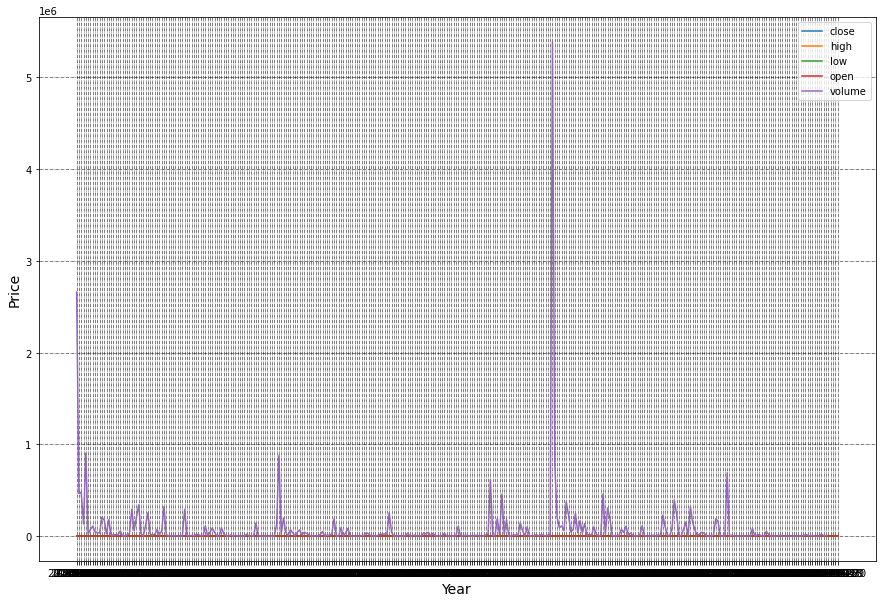

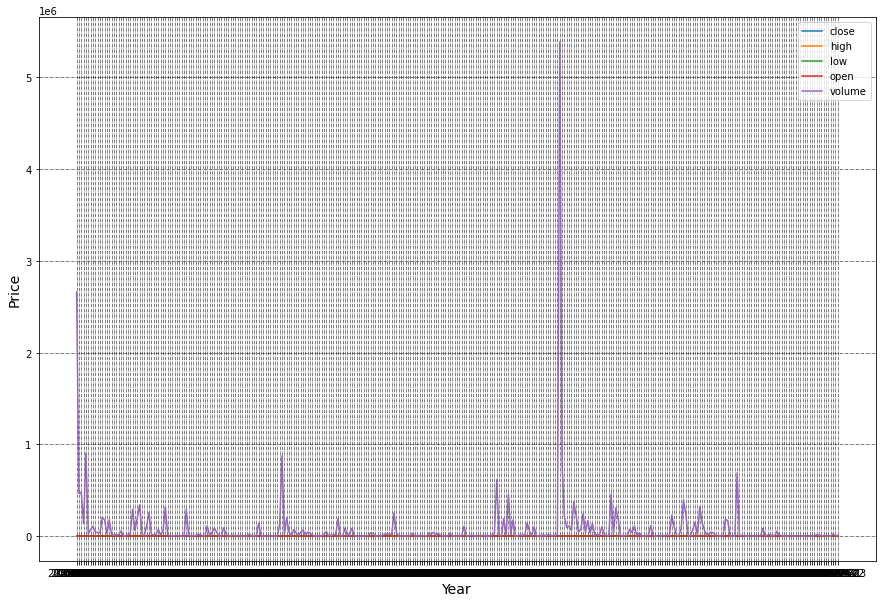

[2021-06-09    9.683864
 2021-06-10    9.703366
 2021-06-11    9.752130
 2021-06-14    9.722871
 2021-06-15    9.713120
                 ...   
 2022-09-19    9.920000
 2022-09-20    9.890000
 2022-09-21    9.920000
 2022-09-22    9.920000
 2022-09-23    9.890000
 Name: close, Length: 327, dtype: float64,
 2021-06-09    9.722872
 2021-06-10    9.722871
 2021-06-11    9.752130
 2021-06-14    9.752127
 2021-06-15    9.729698
                 ...   
 2022-09-19    9.920000
 2022-09-20    9.890000
 2022-09-21    9.920000
 2022-09-22    9.925000
 2022-09-23    9.930000
 Name: high, Length: 327, dtype: float64,
 2021-06-09    9.654607
 2021-06-10    9.664358
 2021-06-11    9.693616
 2021-06-14    9.695565
 2021-06-15    9.693615
                 ...   
 2022-09-19    9.920000
 2022-09-20    9.890000
 2022-09-21    9.890000
 2022-09-22    9.920000
 2022-09-23    9.890000
 Name: low, Length: 327, dtype: float64,
 2021-06-09    9.654607
 2021-06-10    9.683863
 2021-06-11    9.703369
 2021-06-1

In [200]:
def dotest(st= True):
    ticker_data = []
    for i in basic_indicators:
        ind = full_data[i]
        snp_ind = clean(snp[i])
        if test_ticker not in ind:
            raise Exception("choose different ticker for testing")
        d = clean(ind[test_ticker])
        if st and not i=="Volume":
            d = (clean(d/snp_ind))
        else:
            d = (d)
        d = pd.Series(d, name=i.lower())
        ticker_data.append(d)
    visualize_stock_mult(ticker_data[:])
    return ticker_data

ticker_data = dotest(True)
dotest(False)

In [206]:
ticker_data = pd.DataFrame(ticker_data).T

In [210]:
diff = ticker_data['close'].diff()[1:]
snp_diff = snp["Close"].diff()[1:]
display(snp_diff)
perc = diff/ticker_data['close'][:-1].tolist()
snp_perc = snp_diff/snp["Close"][:-1].tolist()
perc.name = 'perc_change'
st_perc = clean(snp_perc - perc)
st_perc.name = "st_perc"
st_perc

2000-10-19   -0.432693
2000-10-20   -0.144231
2000-10-23   -0.480769
2000-10-24   -0.480769
2000-10-25   -0.769231
                ...   
2022-09-26    0.400002
2022-09-27   -1.119999
2022-09-28   -0.630001
2022-09-29   -1.150002
2022-09-30    0.900002
Name: Close, Length: 5522, dtype: float64

2021-06-10    0.004004
2021-06-11    0.015927
2021-06-14    0.026220
2021-06-15   -0.019273
2021-06-16   -0.017235
                ...   
2022-09-26    0.009174
2022-09-27   -0.025455
2022-09-28   -0.014692
2022-09-29   -0.027219
2022-09-30    0.021898
Name: st_perc, Length: 331, dtype: float64

In [232]:
test_indicators = get_data_for_ticker(test_ticker, standardize=True).dropna()
print(test_indicators.shape)
test_indicators.head()

(593, 18)


,close,high,low,open,volume,wma,macdhist,rsi,cci,stochdif,bbupper,bbmiddle,bblower,willr,adx,obv,mfi,perc_change
2020-05-19,0.097051,0.098765,0.094332,0.093621,46100.0,0.100288,-0.000392,42.100577,-58.340041,-4.355075,0.102044,0.097264,0.092484,54.894927,35.987427,1329500.0,42.100577,-0.050354
2020-05-20,0.091040,0.096150,0.090363,0.096373,49400.0,0.099571,-0.000679,36.288275,-149.675378,-3.543706,0.100789,0.095338,0.089887,95.955648,37.141380,1280100.0,36.288275,0.075107
2020-05-21,0.082180,0.094538,0.078335,0.094937,103200.0,0.098316,-0.001370,29.764562,-266.446792,2.383763,0.103891,0.092404,0.080917,85.125164,39.243848,1176900.0,29.764562,0.066976
2020-05-22,0.083502,0.088268,0.074502,0.082444,137300.0,0.097200,-0.001625,31.735835,-232.776248,2.588294,0.100863,0.089422,0.077980,68.712179,41.420088,1314200.0,31.735835,-0.067604
2020-05-26,0.085344,0.090313,0.082204,0.084735,135900.0,0.096246,-0.001556,34.496522,-122.792352,8.608658,0.098857,0.087824,0.076790,62.305865,42.820992,1450100.0,34.496522,0.001052


In [6]:
k = 30
ind = 250
visualize_stock_mult([test_indicators.iloc[ind:ind+k][i] for i in moving_indicators])
visualize_stock_mult([normalize(test_indicators.iloc[ind:ind+k][i]) for i in stationary_indiators])

NameError: name 'moving_indicators' is not defined

In [12]:
def normalize_mult(ts_list):
    if not isinstance(ts_list,list):
        ts_list = [ts_list]
    norm_ts_list = []
    for ts in ts_list:
        if ts.name in stationary_indiators:
            norm_ts_list.append(pd.Series(maxabs_scale(ts), name=ts.name))
        else:
            norm_ts_list.append(pd.Series(minmax_scale(ts), name=ts.name))
    return norm_ts_list

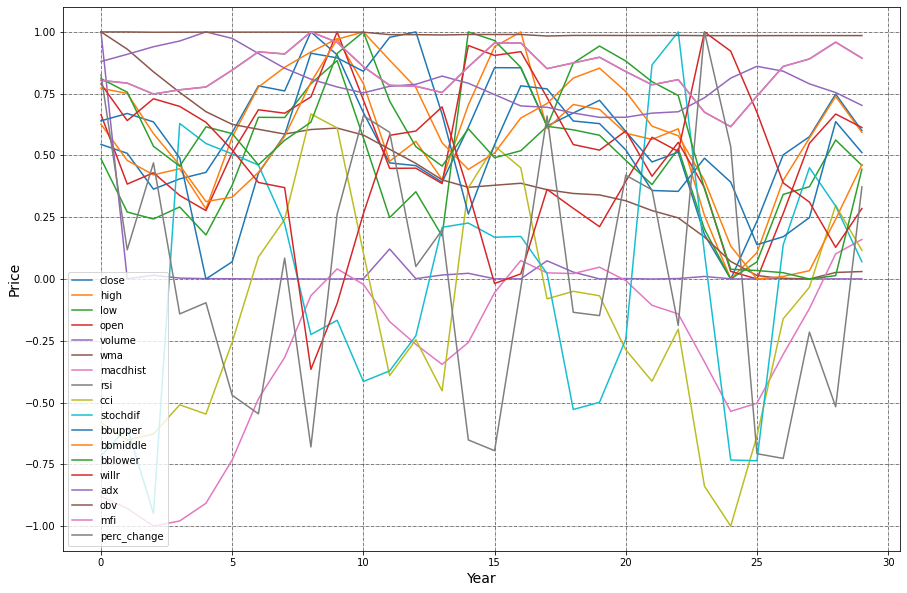

In [226]:
t_stat_inds = [test_indicators.iloc[ind:ind+k][i] for i in test_indicators.columns]
n_stat_inds = normalize_mult(t_stat_inds)
visualize_stock_mult(n_stat_inds)

In [154]:
i = 30
s_t = test_indicators[i-30:i]
stn = pd.DataFrame(normalize_mult([s_t[col] for col in s_t])).T
stn.index = s_t.index

In [13]:
def create_slices_for_ticker(ticker, full_data = full_data, k = 20, lookahead = 0, standardize = True, ):
    indicators = get_data_for_ticker(ticker, full_data=full_data, standardize=standardize)
    if indicators is None:
        return None
    indicators = indicators.dropna()
    slices = []
    targets = []
    dates = []
    for i in range(k, len(indicators)):
        slice = indicators.iloc[i-k: i]
        slice_norm = pd.DataFrame(normalize_mult([slice[col] for col in slice])).T
        slice_norm.index = slice.index
        slices.append(slice_norm)

        pred = indicators.iloc[i]
        targets.append(pred['perc_change'])
        dates.append(pred.name)
    return slices, targets, dates

In [18]:
from tqdm import tqdm

def get_all_sliced_data(data, tickers, standardize):
    slices = []
    targets = []
    dates = []
    for ticker in tqdm(tickers):
        res = create_slices_for_ticker(ticker,full_data=data, standardize=standardize)
        if res is None:
            continue
        s,t,d = res
        slices.extend(s)
        targets.extend(t)
        dates.extend(d)

    return slices, targets, dates

In [14]:
def create_train_test_data(slices, targets, dates, classification = True):
    slices = np.asarray(slices)
    targets = np.array(targets)
    targets_classification = targets>0
    dates = np.array(dates)
    cutoff = '2022-01-01'
    date_inds = dates > cutoff
    test_inds = date_inds
    train_inds = np.logical_not(date_inds)
    X_train, X_test = slices[train_inds], slices[test_inds]
    if classification:
        y_train, y_test = targets_classification[train_inds], targets_classification[test_inds]
    else:
        y_train, y_test = targets[train_inds], targets[test_inds]
    return (X_train, X_test, y_train, y_test)

In [263]:
(test_slices, test_targets, test_dates) = create_data_for_ticker(test_ticker, standardize=True)

In [15]:
X_train, X_test, y_train, y_test = create_train_test_data(test_slices,test_targets,test_dates)

NameError: name 'test_slices' is not defined

In [275]:
np.unique(y_test, return_counts=True)

(array([False,  True]), array([35543, 41101]))

In [278]:
35543/(35543+41101)

0.4637414539950942

In [16]:
def evaluate_model(X_train, X_test, y_train, y_test):
    # start with a simpler model - 1 layer
    # epochs - maybe get to 100, save every 10 epochs
    # try leaving it as regression

    model = models.Sequential()
    model.add(layers.Conv1D(16, 4, activation='relu', input_shape=(20, 18)))
    model.add(layers.Dropout(0.5)) # check order of dropout
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation="sigmoid"))
    # Binary classification 
    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=15, 
                        validation_data=(X_test, y_test))

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    return model, test_acc

In [17]:
# repeat experiment
def repeat_experiment(X_train, X_test, y_train, y_test):
	scores = list()
	for r in range(10):
		model, score = evaluate_model(X_train, X_test, y_train, y_test)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)

	def summarize_results(scores):
		print(scores)
		m, s = np.mean(scores), np.std(scores)
		print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

	summarize_results(scores)

In [22]:
slice_data, target_data, dates_data = get_all_sliced_data(full_data, random.sample(nasdaq_tickers, 500), False)

100%|██████████| 500/500 [1:09:20<00:00,  8.32s/it]  


In [23]:
X_train, X_test, y_train, y_test = create_train_test_data(slice_data, target_data, dates_data)

Epoch 1/15
28503/28503 [==============================] - 48s 2ms/step - loss: 0.6602 - accuracy: 0.5796 - val_loss: 0.6662 - val_accuracy: 0.5981
Epoch 2/15
28503/28503 [==============================] - 84s 3ms/step - loss: 0.6574 - accuracy: 0.5796 - val_loss: 0.6658 - val_accuracy: 0.5981
Epoch 3/15
28503/28503 [==============================] - 159s 6ms/step - loss: 0.6564 - accuracy: 0.5794 - val_loss: 0.6651 - val_accuracy: 0.5981
Epoch 4/15
28503/28503 [==============================] - 121s 4ms/step - loss: 0.6558 - accuracy: 0.5795 - val_loss: 0.6689 - val_accuracy: 0.5981
Epoch 5/15
28503/28503 [==============================] - 35s 1ms/step - loss: 0.6554 - accuracy: 0.5794 - val_loss: 0.6662 - val_accuracy: 0.5981
Epoch 6/15
28503/28503 [==============================] - 33s 1ms/step - loss: 0.6552 - accuracy: 0.5793 - val_loss: 0.6648 - val_accuracy: 0.5981
Epoch 7/15
28503/28503 [==============================] - 33s 1ms/step - loss: 0.6550 - accuracy: 0.5795 - val_loss:

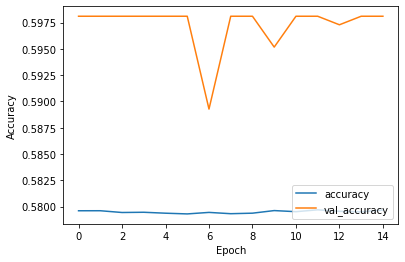

In [24]:
model, acc = evaluate_model(X_train, X_test, y_train, y_test)

In [25]:
y_pred = model.predict(X_test)

2387/2387 [==============================] - 3s 715us/step


In [38]:
y_train

array([False,  True, False, ..., False,  True,  True])

In [27]:
np.unique(y_pred, return_counts=True)

(array([0.04758031, 0.04883917, 0.05580806, ..., 0.49075642, 0.4907568 ,
        0.49075878], dtype=float32),
 array([   1,    1,    1, ...,    1,    1, 2011]))

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

0.5827241422774396


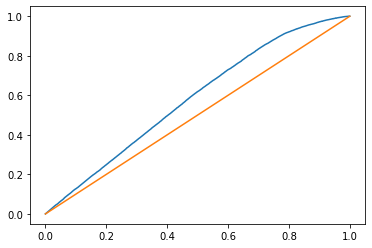

In [36]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
print(roc_auc_score(y_test, y_pred))

/Users/williamyang/opt/anaconda3/envs/stock/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


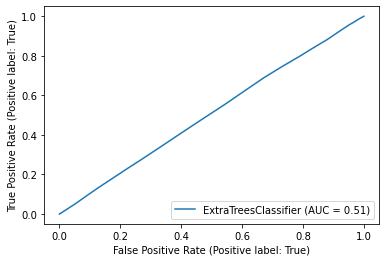

In [47]:
plot_roc_curve(et, X_test.reshape(X_test.shape[0],-1), y_test)

In [37]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier()
et.fit(X_train.reshape(X_train.shape[0],-1), y_train)

y_pred = et.predict(X_test.reshape(X_test.shape[0],-1))
y_prob = et.predict_proba(X_test.reshape(X_test.shape[0],-1))
print(accuracy_score(y_test, y_pred))
display(confusion_matrix(y_test, y_pred))
roc_curve(y_test, y_prob[:,0])

0.5032832586837899


array([[18587, 16534],
       [21061, 19505]])

ValueError: y should be a 1d array, got an array of shape (75687, 2) instead.

Epoch 1/10
6633/6633 [==============================] - 10s 1ms/step - loss: 0.6830 - accuracy: 0.5555 - val_loss: 0.6710 - val_accuracy: 0.6028
Epoch 2/10
6633/6633 [==============================] - 9s 1ms/step - loss: 0.6762 - accuracy: 0.5599 - val_loss: 0.6596 - val_accuracy: 0.6028
Epoch 3/10
6633/6633 [==============================] - 8s 1ms/step - loss: 0.6754 - accuracy: 0.5602 - val_loss: 0.6581 - val_accuracy: 0.6028
Epoch 4/10
6633/6633 [==============================] - 8s 1ms/step - loss: 0.6747 - accuracy: 0.5605 - val_loss: 0.6598 - val_accuracy: 0.6028
Epoch 5/10
6633/6633 [==============================] - 9s 1ms/step - loss: 0.6744 - accuracy: 0.5601 - val_loss: 0.6561 - val_accuracy: 0.6028
Epoch 6/10
6633/6633 [==============================] - 8s 1ms/step - loss: 0.6742 - accuracy: 0.5601 - val_loss: 0.6603 - val_accuracy: 0.6028
Epoch 7/10
6633/6633 [==============================] - 9s 1ms/step - loss: 0.6740 - accuracy: 0.5604 - val_loss: 0.6572 - val_accuracy

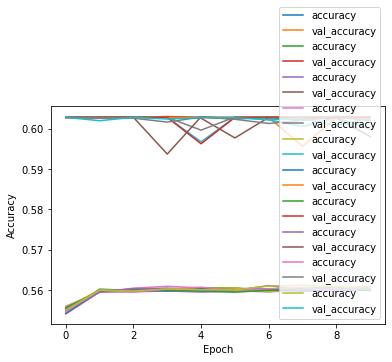

In [98]:
repeat_experiment(X_train, X_test, y_train, y_test)

In [ ]:
with open('stock_slice_data.pkl', 'rb') as inp:
    slice_data = pickle.load(inp)
    target_data = pickle.load(inp)
    dates_data = pickle.load(inp)

Date
2000-10-18     5.188810
2000-10-19     5.048149
2000-10-20     5.001264
2000-10-23     4.844973
2000-10-24     4.688684
                ...    
2022-09-19    43.549999
2022-09-20    43.299999
2022-09-21    43.480000
2022-09-22    44.000000
2022-09-23    43.599998
Name: Adj Close, Length: 5518, dtype: float64

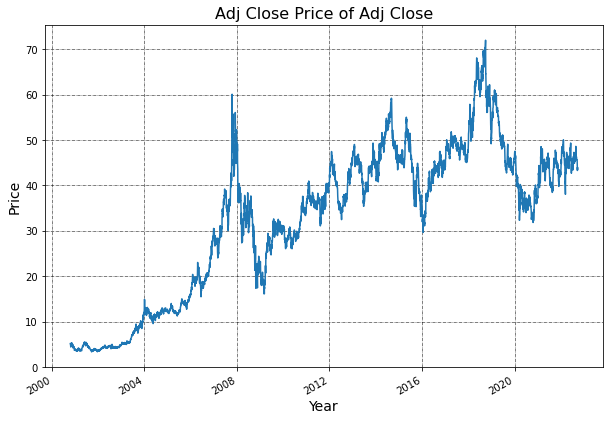

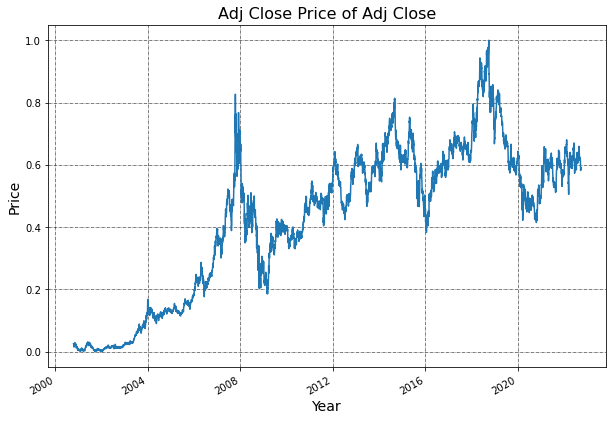

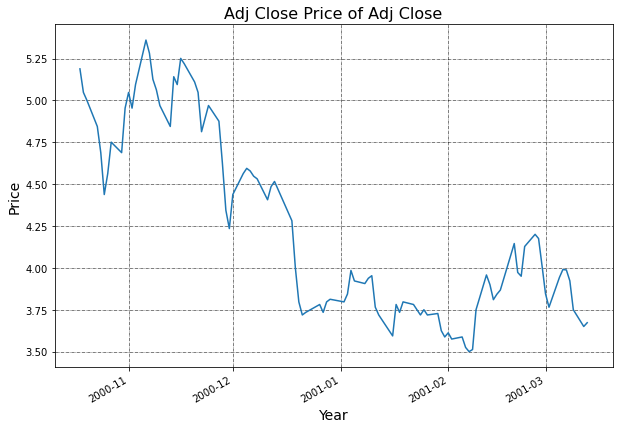

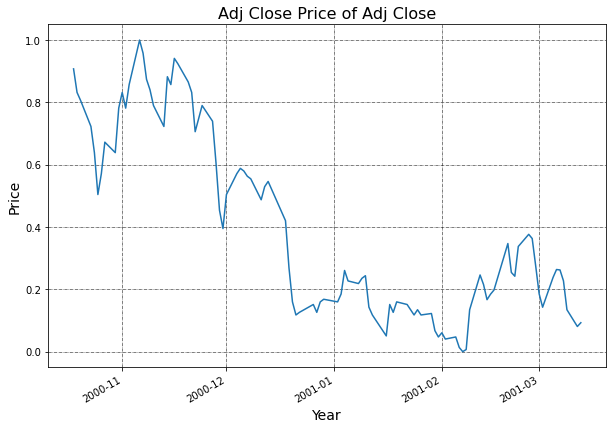

In [82]:
display(snp)
visualize_stock(snp)
visualize_stock(normalize(snp))
visualize_stock(snp[:100])
visualize_stock(normalize(snp[:100]))

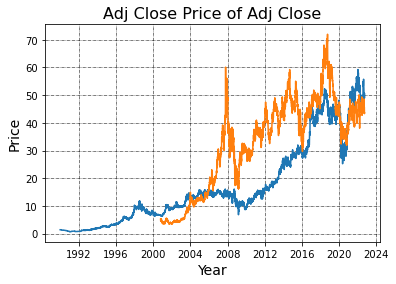

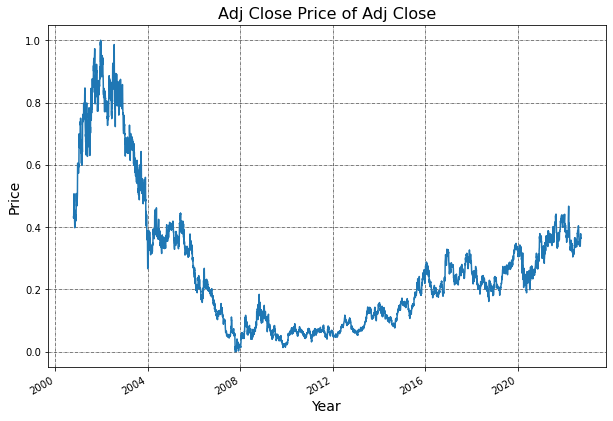

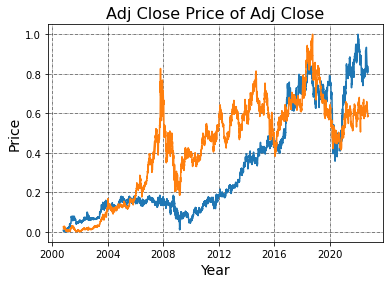

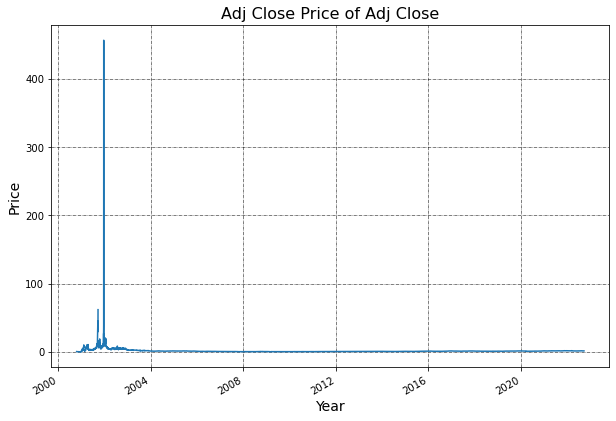

In [164]:
snp_norm = normalize(snp)
visualize_stock_mult(test,snp)
test_st_1 = test/snp
visualize_stock(normalize(clean(test_st_1)))
test_norm = normalize(test[snp.index])
visualize_stock_mult(test_norm, snp_norm)
test_st_2 = clean(test_norm/snp_norm)
visualize_stock(test_st_2) # BAD

In [104]:
empty_cols = [col for col in data.columns if data[col].isnull().all()]
data.drop(empty_cols, axis=1, inplace=True)

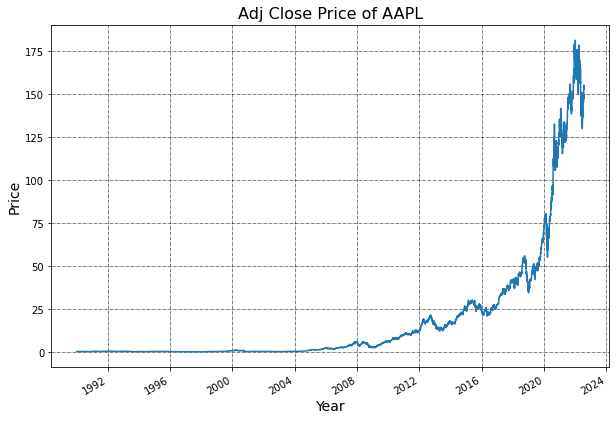

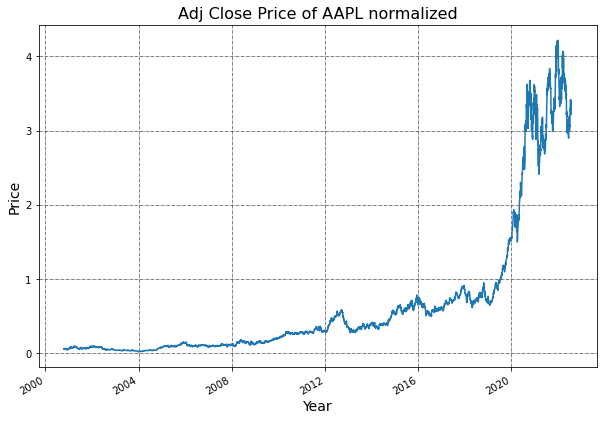

In [68]:
aapl = data["AAPL"]
visualize_stock(aapl)
aapl_norm = aapl/snp
visualize_stock(aapl_norm, "AAPL normalized")

In [102]:
# GET BUY/HOLD/SELL
window_size = 11
positions = pd.DataFrame(index=snp.index)
snp_temp = snp
for counter_row, (date, close_price) in enumerate(zip(snp_temp.index, snp_temp)):
    position = "HOLD"
    if counter_row > window_size:
        begin_ind = counter_row - window_size
        end_ind = begin_ind + window_size
        mid_ind = (begin_ind + end_ind)//2

        window = snp.iloc[begin_ind:end_ind]
        if mid_ind == begin_ind + np.argmin(window):
            position = "BUY"
        elif mid_ind == begin_ind + np.argmax(window):
            position = "SELL"
    positions.loc[date, "Position"] = position
display(positions)
positions["Position"].value_counts()

,Position
Date,
2000-10-18,HOLD
2000-10-19,HOLD
2000-10-20,HOLD
2000-10-23,HOLD
2000-10-24,HOLD
...,...
2022-07-19,HOLD
2022-07-20,HOLD
2022-07-21,HOLD


HOLD    4802
SELL     343
BUY      330
Name: Position, dtype: int64

In [155]:
action = positions.iloc[20:]["Position"]
X_train, X_test, y_train, y_test = train_test_split(features, action, test_size=0.3, random_state=42)

et = ExtraTreesClassifier().fit(X_train, y_train)
et.score(X_test,y_test)
y_pred = et.predict(X_test)

In [170]:
def run_simulation(y_pred, y_optimal, data):
    starting_amount = 10000
    sim_money = starting_amount
    sim_stocks = 0
    opt_money = starting_amount
    opt_stocks = 0
    for date, pred, opt in zip(y_optimal.index, y_pred, y_optimal):
        price = data.loc[date]
        if pred == "BUY":
            sim_stocks += sim_money/price
            sim_money = 0
        if pred == "SELL":
            sim_money += sim_stocks*price
            sim_stocks = 0
        if opt == "BUY":
            opt_stocks += opt_money/price
            opt_money = 0
        if opt == "SELL":
            opt_money += opt_stocks*price
            opt_stocks = 0
    sim_money += sim_stocks*price
    opt_money += opt_stocks*price
    print("Simulated gain ratio:", sim_money/starting_amount)
    print("Optimal gain ratio:", opt_money/starting_amount)
    return sim_money/starting_amount, opt_money/starting_amount

In [171]:
run_simulation(y_pred, y_test, snp)

Simulated gain ratio: 0.5906536736329682
Optimal gain ratio: 4.8883757320941505


(0.5906536736329682, 4.8883757320941505)